In [4]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import sql    
from tqdm import tqdm
# from functions import *
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import warnings
warnings.filterwarnings("ignore")

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'id': 'constituents'})
symbols = []
names = []
sectors = []
industries = []

for row in table.find('tbody').find_all('tr')[1:]:
    cells = row.find_all('td')
    if len(cells) >= 4:
        symbol = cells[0].text.strip()
        name = cells[1].text.strip()
        sector = cells[3].text.strip()
        industry = cells[4].text.strip()
        symbols.append(symbol)
        names.append(name)
        sectors.append(sector)
        industries.append(industry)

df = pd.DataFrame({
    'Symbol': symbols,
    'Name': names,
    'Sector': sectors,
    'Industry': industries
})


In [5]:
url = 'https://stockanalysis.com/list/nasdaq-100-stocks/'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
res = soup.find_all('a')

In [8]:
# us500_l = sorted(df['Symbol'].tolist())
us100_l = [i.text for i in res[38:139]]

In [10]:
import yfinance as yf
df_list = []
for stock in tqdm(us100_l):
    df = yf.download(stock, interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
    df['code'] = stock
    df_list.append(df)
df = yf.download("^NDX", interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
df['code'] = "US100"
df_list.append(df)
final = pd.concat(df_list)
final['datetime'] = final.index
pivoted = final.pivot(columns='code', values='Close', index='datetime')
pivoted.to_parquet("US100.parquet")

100%|██████████| 101/101 [00:22<00:00,  4.52it/s]


In [ ]:
import yfinance as yf
df_list = []
for stock in tqdm(us500_l):
    df = yf.download(stock, interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
    df['code'] = stock
    df_list.append(df)
df = yf.download("^SPX", interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
df['code'] = "US100"
df_list.append(df)
final = pd.concat(df_list)
final['datetime'] = final.index
pivote = final.pivot(columns='code', values='Close', index='datetime')
pivote.to_parquet("US500.parquet")


In [12]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
rets = []
for code in list(pivoted.columns):
    if code == "US100": continue
    index = "US100"
    rolling = 5
    ret = pivoted[[code, index]].pct_change()
    ret['stock_price'] = pivoted[code]
    ret['index_price'] = pivoted["US100"]
    ret['ret_diff'] = ret[code] - ret["US100"]
    # type 2
    ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
    ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
    ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

    # # check direction
    ret['lag10'] = ret['stock_price'].shift(5)
    ret['change_stock'] = (ret['stock_price'] - ret['lag10'])/ret['lag10']
    ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)
    
    # # check if the direction are the same, if not, tned to not being a mean reversion
    ret['lag10_twii'] = ret['index_price'].shift(5)
    ret['change_twii'] = (ret['index_price'] - ret['lag10_twii'])/ret['lag10_twii']
    ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
    ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)
    ret['code'] = code
    ret = ret[(ret['stdize_ret_diff'] >= 2) & (ret['filter_1'] == 1) & (ret['filter_2'] == 1)][['filter_1', 'filter_2', 'stdize_ret_diff', 'direction', 'code']].dropna()
    rets.append(ret)

In [16]:
dfs = pd.concat(rets)
dfs['time'] = dfs.index.hour
final1 = dfs[dfs['time'] != 9]
final1

code,filter_1,filter_2,stdize_ret_diff,direction,code,time
datetime,,,,,,
2024-07-05 10:05:00-04:00,1,1,2.689753,-1,ARM,10
2024-07-25 10:10:00-04:00,1,1,6.465075,1,ARM,10
2024-07-25 10:20:00-04:00,1,1,2.361491,-1,ARM,10
2024-08-02 10:00:00-04:00,1,1,2.204692,1,ARM,10
2024-08-02 10:15:00-04:00,1,1,3.025920,1,ARM,10
2024-07-25 10:10:00-04:00,1,1,2.196120,1,CEG,10
2024-07-25 13:05:00-04:00,1,1,3.811029,-1,DASH,13
2024-08-13 12:00:00-04:00,1,1,2.168898,-1,ILMN,12
2024-08-01 10:00:00-04:00,1,1,2.034966,-1,MRNA,10


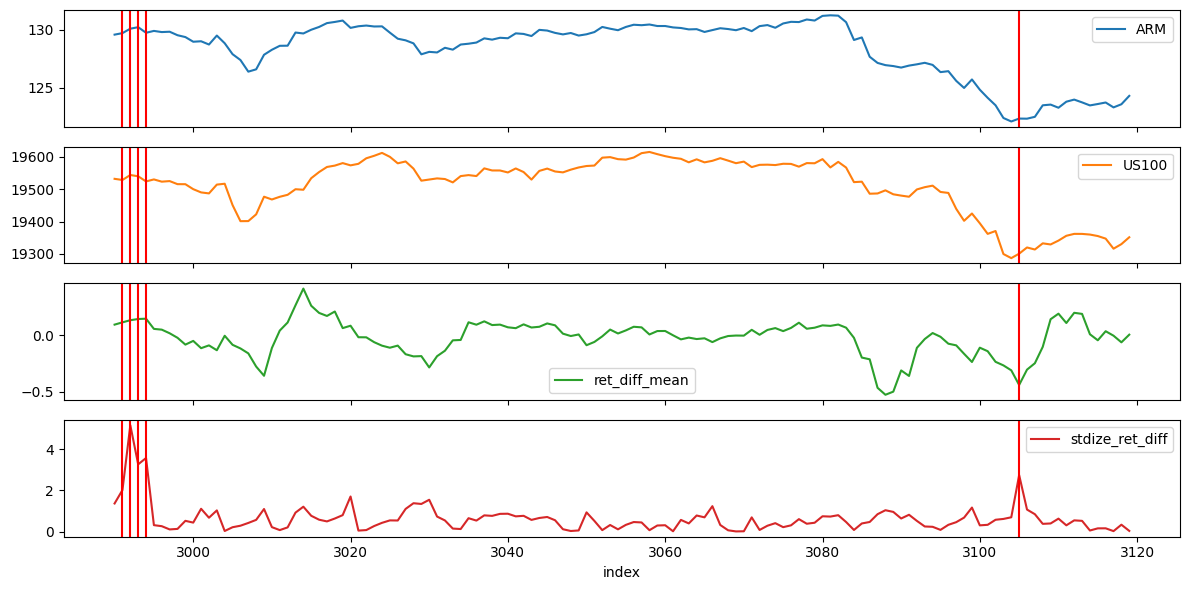

code,ARM,US100,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,ARM_lag60,TWII_lag60,lag10,direction,target_60mins
index,,,,,,,,,,,,
88,166.15,20027.41,0.002293,0.181592,0.397076,2.174014,88,169.37,20110.84,166.60,1,0.019
159,177.64,20360.53,-0.002336,0.084347,-0.203601,2.386159,159,179.91,20392.08,178.43,1,0.013
265,183.75,20409.08,0.000580,0.051365,0.110868,2.147127,265,187.07,20519.86,183.46,-1,0.018
422,185.58,20640.41,-0.001008,0.063490,-0.142074,2.221840,422,184.71,20632.10,186.64,1,0.005
456,175.52,20294.61,-0.003456,0.133045,-0.394648,2.940305,456,176.77,20308.39,176.02,1,0.007
457,175.36,20292.28,-0.006726,0.172564,-0.417831,2.382336,457,176.99,20302.84,175.73,1,0.009
519,179.47,20342.91,-0.003631,0.090500,-0.248301,2.703533,519,179.62,20418.78,181.62,1,0.001
672,173.32,20296.54,-0.004717,0.192698,-0.482153,2.477636,672,175.33,20391.04,174.19,1,0.012
816,163.84,19833.94,0.001062,0.062701,0.150187,2.378346,816,163.52,19903.96,161.70,-1,0.002


In [19]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
code = 'ARM'
rolling = 5
ret = pivoted[["ARM", "US100"]].pct_change()
ret['ret_diff'] = ret[code] - ret['US100']
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
ret[code] = pivoted[code].shift(-1)
ret['US100'] = pivoted['US100'].shift(-1)

ret['index'] = [i for i in range(len(ret))]

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-12)
ret[f'TWII_lag60'] = ret["US100"].shift(-12)
ret['lag10'] = ret[code].shift(-4)

ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = abs(np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3))

# ret['signal_defineby_prev_ret'] = 
# specific print
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
start = 2990
# end = len(ret) - 100
end = 3120
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()

# check to long or short
ret[ret['stdize_ret_diff'] >= bm]